In [1]:
#2021.06.30. WED
#Hankyeong

#00. 패키지 호출
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import sys
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense,  Flatten, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, load_model

#00-1. 시각화옵션 설정하기. 
%matplotlib inline

#00-2. 씨드넘버 설정하기. 
np.random.seed(2021)
tf.random.set_seed(2021)

#00-3. warning message ignore
warnings.filterwarnings(action='ignore')

In [2]:
#01. MNIST 데이터셋 전처리하기.  
#(1) 데이터셋 불러오기. 
(X_train,y_train), (X_test, y_test) = mnist.load_data()

#(2) train, test 데이터셋 차원 확인하기. 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
#(3) 3차원 데이터셋을 2차원으로 변환하기. 
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

#(4) feature 데이터 스케일링 처리하기. 
X_train_mm = MinMaxScaler().fit_transform(X_train)
X_test_mm = MinMaxScaler().fit_transform(X_test)

#(5) target 데이터 원핫인코딩 처리하기. 
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

#(7) 형태 재설정하기. 
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

#(8) train, test 데이터셋 차원 재확인하기. 
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [4]:
#06. CNN 모델로 설정, 학습, 예측, 평가하기. + Pooling + Dropout
#(1) 모델 설정하기. 
model = Sequential([
    Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    Flatten(),                              
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

#(2) 모델 요약 정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4719104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [5]:
#MEMO. Dropout() 층은 쉽게 말해 훈련 연산 중 일부 노드를 꺼두는 것임. 

In [6]:
#(3) 모델 컴파일 설정하기. 
model.compile(
    optimizer = 'adam',
    loss      = 'categorical_crossentropy',
    metrics   = 'accuracy'
)

#(4) 모델의 저장경로 및 checkpointer 객체 정의하기. 
model_path = '../../model/mnist_best_CNN_model.h5'
checkpointer = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

#(5) earlystopping 객체 정의하기. 
earlystopping = EarlyStopping(patience=15)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X_train,Y_train,
    validation_split=0.2,
    epochs=30000, 
    batch_size=250, 
    verbose=0, 
    callbacks=[checkpointer, earlystopping]
)

#(7) best 모델 할당하기. 
best_model = load_model(model_path)

#(8) 모델 예측 및 평가하기. 
accuracy_score = best_model.evaluate(X_test, Y_test)
accuracy_score

313/313 [==============================] - 1s 2ms/step - loss: 0.0347 - accuracy: 0.9880


[0.03470422327518463, 0.9879999756813049]

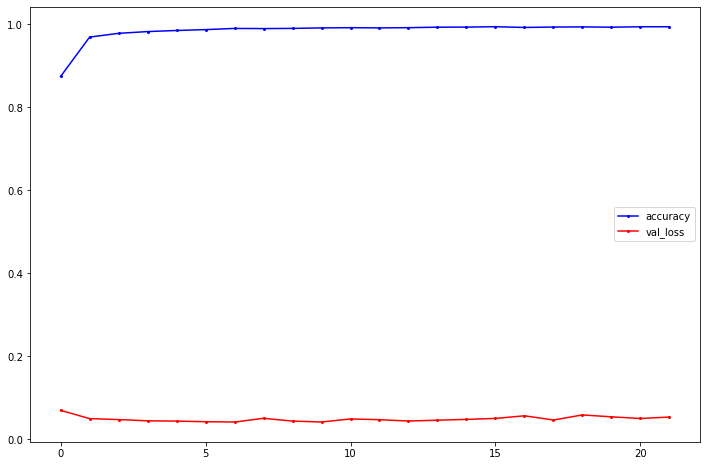

In [7]:
#(9) 학습과정 시각화하기. 
y_vloss = model_fit.history['val_loss']
y_accuracy = model_fit.history['accuracy']
x_len = np.arange(len(y_vloss))
plt.figure(figsize=(12,8))
plt.plot(x_len, y_accuracy, 'bo-', markersize=2, label='accuracy')
plt.plot(x_len, y_vloss, 'ro-', markersize=2, label='val_loss')
plt.legend()
plt.show()